In [15]:
%reload_ext autoreload
%autoreload 2


import sys
sys.path.append("..")

from utils.utils import load_sql_to_df, plot_history, save_to_sql
from custom_datasets.move_as_tensor import MoveAsTensorDataset, MoveAsTensorDatasetOnlineTransform
import board_representation.board_representation as br
import board_representation.sentimate as br_sentimate

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from training.training import train_loop, test_model, Trainer
from models.move_evaluation import SentimateNet, SentimateNetSmaller, SentimateNetSkipLayer, SentimateNetWithBatchNorm
from playing.agents import *

import random

import chess
import chess.engine
from stockfish import Stockfish
import pandas as pd
from tqdm import tqdm

import pytorch_lightning as pl

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# def filter_func(row):
#     board = chess.Board(row['position'])
#     return board.is_legal(chess.Move.from_uci(row['move']))

# tables = ["classified_moves_with_comments", "chessbase_moves_with_nags", "moves_from_books", "random_moves"]
# classified_moves = [load_sql_to_df(f"SELECT position, move, sentiment FROM {table_name}", "../../chess.db") for table_name in tables]
# classified_moves = pd.concat(classified_moves)
# classified_moves = classified_moves[classified_moves.apply(filter_func, axis=1)]
# classified_moves

In [4]:
classified_moves = load_sql_to_df(f"SELECT fen, move, sentiment FROM sentimate_v1", "../../data/chess_moves_quality.db")
classified_moves.rename(columns={"fen": "position"}, inplace=True)

In [5]:
# save_to_sql(classified_moves, db_filename="../../chess.db", table_name="sentimate_training_set", if_exists='replace')

In [6]:
train_df, test_df = train_test_split(classified_moves, test_size=0.005, random_state=0)
display(train_df)
display(test_df)

,position,move,sentiment
8648461,rn1k3Q/pp1qb3/3p3B/2p5/8/2NP3b/PPP2r2/2KRR3 b ...,e7f8,0
9304380,R7/P5k1/8/6p1/5P2/5P2/7K/r7 b - - 0 3,g5g4,0
7509264,7R/1p6/6kp/p3B3/7b/3b3P/PP6/2K5 w - - 2 41,h8h7,0
10339421,r1bq1rk1/1pp3bp/3p4/p2Pp2B/1nP5/2N1P1PP/PP1N4/...,b4c2,0
10517121,r2q1rk1/pb2ppbp/1p3np1/1PnP4/2Q5/2N3P1/P2PNPBP...,h2h4,0
...,...,...,...
10638075,r3k2r/p1pp1ppp/b1p5/2bnP3/2P4q/PP6/4QPPP/RNB1K...,e2f3,0
5157699,r2Nk2r/ppp5/3p1n2/2b1p3/2B1P1b1/2NP1Pp1/PPPQ1P...,g4f3,1
2215104,8/2R5/7k/4B1b1/1P2b1B1/1r4P1/5P2/4K3 b - - 0 54,b3b1,0
1484405,8/5B2/6pk/1bp1p1R1/p1P1P2P/3P2K1/1r6/8 b - - 0 50,h6g7,1


,position,move,sentiment
277564,r4rk1/pbqp2pp/4p1nn/2p1Pp2/2P5/P1BBQN2/2P2PPP/...,f3g5,1
8495515,2rr2k1/pp3pp1/3bb3/n2p3p/3P1B1P/1B3PP1/PP3KN1/...,d6c5,0
8223789,r5k1/ppp2pp1/8/2b5/3N2q1/8/P1P2PB1/R1B1R1K1 w ...,f2f3,0
10333628,r1b1k2r/pp1n1p1p/1qn1p3/3pP1P1/1b1P4/5NP1/PP3K...,b6d4,0
2314197,8/3k1p1p/r2p1np1/8/PpN2P2/6P1/1PP4P/1K2R3 b - ...,d6d5,0
...,...,...,...
4273334,3rrnk1/5p1p/p1q3p1/4p1P1/Pbp1P1Q1/6P1/1PB2PK1/...,a4a5,1
1986941,r2qr1k1/1pb2pp1/5n1p/pN2n3/P1p5/2P3Nb/BPQB1PP1...,b5c7,0
8987736,r1b2rk1/pp1p1ppp/1q6/4P3/2Bb4/1Q6/PP2RPPP/RN4K...,b6c5,0
1251003,1r4k1/1p6/2p3p1/p1Pp2p1/P2Pr3/2R1P3/6PP/1R4K1 ...,c3b3,1


In [7]:
train_dataset = MoveAsTensorDatasetOnlineTransform(train_df)
test_dataset = MoveAsTensorDatasetOnlineTransform(test_df)

In [8]:
model = SentimateNet()
model.to(device)
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.95)
scheduler = None

In [23]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=1)

In [11]:
test_model(test_loader, model)

Test Error: Accuracy: 58.32%, Avg loss: 0.688639


In [12]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer, scheduler=scheduler, x_dtype=torch.float32, y_dtype=torch.float32)

In [14]:
trainer.train(1, verbose=True)

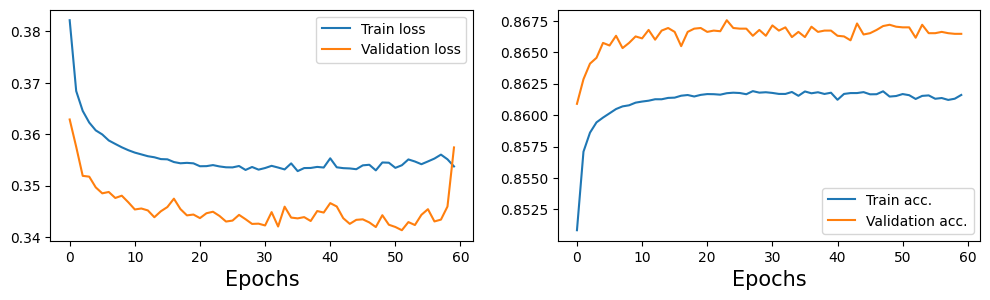

In [23]:
trainer.plot_history()

In [15]:
# test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 86.65%, Avg loss: 0.357439


In [16]:
trainer.best_model()


Loading best params on validation set (epoch 24, accuracy: 86.75%)



SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Dropout(p=0.25, inplace=False)
    (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [19]:
best_model = trainer.best_model()


Loading best params on validation set (epoch 24, accuracy: 86.75%)



In [20]:
random_agent = RandomAgent()
model_agent = ModelAgent(model)

In [24]:
from playing.testing import test_agent, play_game

best_model.to(device)
model_agent = ModelAgent(best_model, convert_fn=br_sentimate.move_to_tensor)
test_agent(model_agent, n_games=1000)

# Test result: {'agent_win': 881, 'opponent_win': 98, 'draw': 21}

100%|██████████| 1000/1000 [16:41<00:00,  1.00s/it]


{'agent_win': 881, 'opponent_win': 98, 'draw': 21}

In [26]:
torch.save(best_model.state_dict(), "../../models/sentimate-original-board-representation/23-12-2/sentimate-23-12-2-best-acc.pth")

In [ ]:
play_game(random_agent, model_agent, verbose=True)